[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/AI-og-helse/blob/main/uke03-dyplæring/03_medisinsk_bildeanalyse_MR.ipynb)

# 🧠 Medisinsk Bildeanalyse med MR og PyTorch

I denne notebook-en skal vi bygge en dyplæringsmodell for å analysere medisinske bilder. Vi går bort fra røntgenbildene vi så på tidligere, og fokuserer nå på **magnetisk resonanstomografi (MR)**-bilder av hjernen.

**Mål:** Vi skal trene et **Convolutional Neural Network (CNN)** til å klassifisere MR-bilder og skille mellom hjerner fra friske kontrollpersoner og personer med demens.

**Datasett:** Vi bruker et lite utvalg fra [OASIS-1](https://www.oasis-brains.org/)-datasettet. Dataene består av 3D MR-bilder i NIfTI-format (`.nii`). For å gjøre oppgaven enklere, vil vi trekke ut ett 2D-snitt fra midten av hver 3D-skanning for å utføre 2D-bildeklassifisering.

**Verktøy:**
- **PyTorch:** Et populært rammeverk for dyp læring.
- **Nibabel:** Et Python-bibliotek for å lese og skrive vanlige medisinske bildeformater, som NIfTI.
- **Scikit-learn:** For datasplitting og evaluering.
- **Matplotlib:** For visualisering.

### Men først: 🔧 miljøoppsett - kode skal fungere både lokalt, i Codespaces samt Google Colab

In [1]:
import sys
import subprocess
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🚀 Kjører i Google Colab")
    
    # Installer nødvendige pakker som ikke er forhåndsinstallert i Colab
    !pip install seaborn --quiet
    
    # Sjekk om mappen allerede eksisterer
    if not os.path.exists('AI-og-helse'):
        print("📥 Laster ned kursmateriell...")
        try:
            # Prøv å klone repositoryet (da være public)
            !git clone https://github.com/arvidl/AI-og-helse.git
            print("✅ Repository klonet vellykket!")
        except:
            print("⚠️ Kunne ikke klone repository automatisk")
            print("💡 Du kan laste opp filer manuelt eller bruke en annen metode")
    
    # Bytt til riktig mappe hvis den eksisterer
    if os.path.exists('AI-og-helse'):
        os.chdir('AI-og-helse')
        print(f"📁 Byttet til mappe: {os.getcwd()}")
    else:
        print("📂 Arbeider i standard Colab-mappe")
        
else:
    print("💻 Kjører i lokal miljø/Codespaces")

# Standard imports som fungerer overalt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Miljø er konfigurert og klart!")

💻 Kjører i lokal miljø/Codespaces
✅ Miljø er konfigurert og klart!


## Detaljert motivasjon og forklaring av medisinsk bildeanalyse med MR og PyTorch

## ✅ Steg 1: Importere nødvendige biblioteker


### Hvorfor dette steget er viktig
Dette steget setter grunnlaget for hele analysen ved å importere alle verktøyene vi trenger. I medisinsk bildeanalyse jobber vi med spesialiserte dataformater og krever kraftige maskinlæringsbiblioteker.

### Hva skjer her
Vi importerer:
- **nibabel**: Et spesialisert bibliotek for å lese medisinske bildeformater som NIfTI (.nii), som er standard for MR-bilder
- **PyTorch**: Et moderne deep learning-rammeverk som gir oss fleksibilitet til å bygge tilpassede nevrale nettverk
- **scikit-learn**: For datasplitting og evalueringsmetrikker
- **matplotlib**: For visualisering av resultater

### Teknisk innsikt
Koden sjekker automatisk hvilken prosessor (regneressurser) som er tilgjengelig (GPU, MPS for Mac, eller CPU) for å optimalisere treningshastigheten. Dette er kritisk for dyplæring siden modellene er beregningsintensive.


## ✅ Steg 2: Laste inn og utforske dataene


### Motivasjon
Før vi kan bygge en AI-modell må vi forstå våre data grundig. MR-bilder er komplekse 3D-strukturer som inneholder rik informasjon om hjernens anatomi hos den enkelete pasient. Vi må konvertere denne informasjonen til et format som en maskinlæringsmodell kan forstå.

### Dataforståelse
OASIS-datasettet inneholder MR-bilder fra personer med og uten demens. Hvert bilde er en 3D-representasjon av en hjerne, men for å forenkle oppgaven ekstraherer vi ett sentralt 2D aksial-snitt fra hver skanning.

### Teknisk prosess
`load_mri_data()` funksjonen:
1. Leser NIfTI-filer ved hjelp av nibabel
2. Ekstraherer det midterste aksiale snittet (antatt å være den mest informative delen)
3. Roterer bildet for korrekt orientering
4. Organiserer data i to klasser (0 = frisk, 1 = demens)

### Hvorfor dette er viktig
- **Datakvalitet**: Vi sikrer at alle bilder har samme format og orientering
- **Klassebalanse**: Vi ser hvor mange eksempler vi har av hver klasse
- **Visualisering**: Vi inspiserer eksempelbilder for å forstå dataene visuelt


## ✅ Steg 3: Forprosessering og klargjøring av data


### Hvorfor forprosessering er kritisk
Rå MR-bilder kan ikke brukes direkte i nevrale nettverk. Vi må:
- Standardisere bildestørrelser
- Normalisere pikselintensiteter
- Dele dataene i trenings- og valideringssett
- Konvertere til PyTorch-tensorer

### Dataset-klassen: En sentral komponent
`MRIDataset` er en egendefinert klasse som arver fra PyTorch's `Dataset`. Den:
- Håndterer lasting av individuelle bilder under trening
- Legger til en kanal-dimensjon (gråtone-bilder har 1 kanal vs RGB som har 3)
- Anvender transformasjoner (resize, normalisering)

### Transformasjoner forklart
- **ToTensor()**: Konverterer NumPy-arrays til PyTorch-tensorer
- **Resize(128,128)**: Standardiserer alle bilder til samme størrelse
- **Normalize(0.5, 0.5)**: Normaliserer pikselintensiteter til området [-1, 1]

### DataLoader: Effektiv batch-prosessering
DataLoader håndterer:
- Gruppering av bilder i batcher (8 bilder om gangen)
- Shuffling av treningsdata for bedre generalisering
- Parallell datainnlasting for økt hastighet


## ✅ Steg 4: Bygge CNN-modellen


### Arkitekturfilosofi
Convolutional Neural Networks (CNN) er ideelle for bildeanalyse fordi de:
- Bevarer romlig informasjon (nabo-piksler er relaterte)
- Deler vekter på tvers av bildet (samme filter brukes overalt)
- Bygger hierarkiske representasjoner (fra kanter til komplekse mønstre)

### Lag-for-lag forklaring

**Konvolusjonslag 1:**
- 16 filtre av størrelse 3x3
- Detekterer grunnleggende mønstre som kanter og teksturer
- ReLU aktivering introduserer ikke-linearitet
- MaxPooling reduserer bildet fra 128x128 til 64x64

**Konvolusjonslag 2:**
- 32 filtre for å fange mer komplekse mønstre
- Videre reduksjon til 32x32 piksler
- Bygger på features fra første lag

**Fully Connected lag:**
- Flater ut 2D feature maps til 1D vektor
- 128 nevroner for å lære komplekse sammenhenger
- Utgang: 2 nevroner (frisk vs demens)

### Hvorfor denne arkitekturen?
- **Progressiv abstraksjon**: Fra piksler til høynivå-features
- **Parameter-effektivitet**: Deling av vekter reduserer overtilpasning
- **Skalerbarhet**: Kan enkelt utvides med flere lag


## ✅ Steg 5: Trene modellen


### Treningsprosessen forklart

**Hyperparametere:**
- **Learning rate (0.001)**: Kontrollerer hvor store oppdateringer vi gjør
- **Epochs (20)**: Antall ganger vi ser hele datasettet
- **Batch size (8)**: Balanse mellom hastighet og minnebruk

**Adam Optimizer:**
- Adaptiv læringsrate for hver parameter
- Kombinerer momentum og adaptive gradienter
- Mer robust enn standard gradient descent

**Cross-Entropy Loss:**
- Standard for klassifiseringsproblemer
- Straffer feilklassifiseringer eksponensielt
- Gir tydelige signaler for læring

### Treningssyklusen
For hver epoke:
1. **Forward pass**: Data sendes gjennom nettverket
2. **Loss beregning**: Hvor feil er prediksjonen?
3. **Backward pass**: Beregn gradienter
4. **Optimalisering**: Oppdater vekter
5. **Validering**: Test på uavhengige data

### Overvåking av fremgang
Vi logger:
- Tap (loss) på både trenings- og valideringsdata
- Nøyaktighet for å måle klassifiserings-prestasjoner
- Dette hjelper oss å oppdage overtilpasning tidlig


## ✅ Steg 6: Evaluere modellen


### Hvorfor evaluering er kritisk
I medisinsk AI er grundig evaluering (livs)viktig. Feil kan få alvorlige konsekvenser for diagnostikk og pasientbehandling.

### Evalueringsmetrikker

**Treningshistorikk:**
- Visualiserer læringsprosessen
- Identifiserer overtilpasning (stor forskjell mellom trenings- og valideringskurver)
- Hjelper med hyperparameter-tuning

**Confusion Matrix:**
- Viser detaljert klassifiseringsytelse
- Identifiserer systematiske feil
- I medisinsk kontekst: Hvor mange friske klassifiseres som syke (falske positiver)?

**Klassifiseringsrapport:**
- **Precision**: Av de vi klassifiserte som syke, hvor mange var faktisk syke?
- **Recall**: Av alle syke pasienter, hvor mange klarte vi å identifisere?
- **F1-score**: Harmonisk gjennomsnitt av precision og recall

### Medisinsk relevans
I demensdiagnostikk er det spesielt viktig å minimere:
- **Falske negativer**: Syke pasienter som ikke får diagnose
- **Falske positiver**: Friske personer som får unødvendig bekymring

### Neste steg for forbedring
- **3D-analyse**: Bruk full volumetrisk informasjon (3D-konvolusjoner)
- **Transfer learning**: Start med forhåndstrente modeller
- **Dataaugmentering**: Øk datasettets størrelse kunstig via ulike (plausible) transformasjoner / pertubasjoner av de opprinnelige data
- **Ensemble-metoder**: Kombiner flere modeller for økt robusthet


Denne strukturerte tilnærmingen gir et solid fundament for medisinsk bildeanalyse og illustrere hvordan moderne AI-teknikker (her veldig forenklet) kan anvendes på utfordrende problemer innen bildediagnostikk

------

### Steg 1: Importere Nødvendige Biblioteker

Først importerer vi alle bibliotekene vi trenger for databehandling, modellbygging, trening og evaluering.

In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Sjekk om GPU eller MPS er tilgjengelig og sett enhet (device)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'Bruker enhet: {device}')

Bruker enhet: mps


In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"MPS tilgjengelig: {torch.backends.mps.is_available()}")
print(f"MPS bygget: {torch.backends.mps.is_built()}")

PyTorch version: 2.6.0
MPS tilgjengelig: True
MPS bygget: True


### Steg 2: Laste inn og Utforske Dataene

Vi antar at dataene blir organisert i en mappestruktur som dette:
```
data/
└── oasis_mri_sample/
    ├── demented/
    │   └── subject_1.nii  (OAS1_0003_MR1.nii.gz)
    └── nondemented/
        └── subject_2.nii  (OAS1_0001_MR1.nii.gz)
```

Vi lager en funksjon som leser alle `.nii`-filene, trekker ut det midterste 2D-snittet fra 3D-volumet, og lagrer bildene sammen med sine etiketter (0 for `nondemented`, 1 for `demented`).

### Laste ned alle tilgjengelige data fra OASIS-datasettet, 

For å laste ned hele datasettet som inneholder 403 subjekter  kan du kjøre `fetch_oasis_vbm()`. 


**Noen viktige merknader:**
1. Den fullstendige nedlastningen vil være stor (~1.5GB)
2. Det vil ta litt tid å laste ned (ca. 3-5 min)
3. Du vil få tilgang til:
   - Gray matter maps (grå substans)
   - Demografiske data
   - Kliniske scorer (inkludert CDR - Clinical Dementia Rating)
   - Alder og kjønn informasjon

Etter at nedlastningen er fullført, kan du kjøre `prepare_oasis_data()` funksjonen som er definerte nedenfor,<br> 
og den vil automatisk organisere alle de tilgjengelige dataene i de riktige mappene.


In [53]:
from nilearn.datasets import fetch_oasis_vbm

# Last ned hele datasettet (403 subjekter)
oasis_dataset = fetch_oasis_vbm()  # Dette vil laste ned alle tilgjengelige data

# For å se hva som ble lastet ned
print("Datasett informasjon:")
print(f"Antall subjekter: {len(oasis_dataset.gray_matter_maps)}")
print("\nTilgjengelige attributter i datasettet:")
for key in oasis_dataset.keys():
    print(f"- {key}")

[fetch_oasis_vbm] Dataset found in /Users/arvid/nilearn_data/oasis1

Datasett informasjon:
Antall subjekter: 403

Tilgjengelige attributter i datasettet:
- gray_matter_maps
- white_matter_maps
- ext_vars
- data_usage_agreement
- description


In [54]:
import os
import shutil
import pandas as pd
from tqdm import tqdm

def prepare_oasis_data(verbose=True):
    """
    Organiserer OASIS MRI-data fra den lokale nilearn-cachen.
    Tilpasset for å kjøre i Jupyter Notebook.
    """
    try:
        # --- Steg 1: Finn stier på en robust måte ---
        # Siden vi er i en notebook, bruker vi relative stier fra gjeldende arbeidsmappe
        current_dir = os.getcwd()  # Dette er 'uke03-dyplæring'
        project_root = os.path.dirname(current_dir)  # Går ett nivå opp
        
        # Definer alle andre stier relativt til prosjektets rotmappe
        base_dir = os.path.join(project_root, 'data', 'oasis_mri_sample')
        demented_dest = os.path.join(base_dir, 'demented')
        nondemented_dest = os.path.join(base_dir, 'nondemented')

        nilearn_data_dir = os.path.expanduser('~/nilearn_data/oasis1')
        metadata_path = os.path.join(nilearn_data_dir, 'oasis_cross-sectional.csv')
        
        print(f"Prosjektets rotmappe funnet: {project_root}")
        print(f"Data vil bli lagret i: {base_dir}")

        # Sjekk om nilearn-data eksisterer
        if not os.path.exists(nilearn_data_dir):
            print("FEIL: Nilearn data-mappe ikke funnet. Installer først datasettet med:")
            print("from nilearn.datasets import fetch_oasis_vbm")
            print("oasis_dataset = fetch_oasis_vbm(n_subjects=20)  # eller ønsket antall")
            return

        if not os.path.exists(metadata_path):
            print(f"FEIL: Kunne ikke finne metadata i '{metadata_path}'.")
            print("Kjør først:")
            print("from nilearn.datasets import fetch_oasis_vbm")
            print("oasis_dataset = fetch_oasis_vbm(n_subjects=20)  # eller ønsket antall")
            return

        # --- Steg 2: Klargjør målmapper ---
        print("Klargjør målmapper...")
        for path in [base_dir, demented_dest, nondemented_dest]:
            if not os.path.exists(path):
                os.makedirs(path)

        # --- Steg 3: Last metadata og finn bildefiler ---
        print(f"Laster metadata fra: {metadata_path}")
        metadata_df = pd.read_csv(metadata_path)

        if verbose:
            print("\nDataset statistikk:")
            print("------------------")
            print("CDR score distribusjon:")
            print(metadata_df['CDR'].value_counts(dropna=True))
            print("\nAntall subjekter med manglende CDR score:", metadata_df['CDR'].isna().sum())
            print("\nAntall unike subjekt-IDer:", metadata_df['ID'].nunique())
            

        print("Søker systematisk etter alle MR-bilder i nilearn-cachen...")
        path_lookup = {}
        for root, dirs, files in os.walk(nilearn_data_dir):
            for filename in files:
                if filename.startswith('mwrc1') and filename.endswith('.nii.gz'):
                    session_id = os.path.basename(root)
                    full_path = os.path.join(root, filename)
                    path_lookup[session_id] = full_path
        
        print(f"Funnet {len(path_lookup)} unike bildefiler for grå substans.")

        # --- Steg 4: Sorter og kopier ---
        print("Kobler metadata til filer og starter sortering...")
        copied_files_count = 0
        for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0], desc="Sorterer filer"):
            session_id = row['ID']
            cdr_score = row['CDR']
            if pd.isna(cdr_score):
                continue
            
            source_path = path_lookup.get(session_id)
            if source_path:
                destination_folder = demented_dest if cdr_score > 0 else nondemented_dest
                dest_file = os.path.join(destination_folder, f"{session_id}.nii.gz")
                shutil.copy2(source_path, dest_file)
                copied_files_count += 1

        # --- Steg 5: Verifiser ---
        demented_count = len(os.listdir(demented_dest))
        nondemented_count = len(os.listdir(nondemented_dest))
        
        print(f"\nOppsett fullført! {copied_files_count} filer ble sortert.")
        print(f"Resultat:")
        print(f"- {demented_count} bilder i mappen 'demented'")
        print(f"- {nondemented_count} bilder i mappen 'nondemented'")

        if verbose:
            print("\nSorteringsdetaljer:")
            print("------------------")
            print(f"Totalt antall bildefiler funnet: {len(path_lookup)}")
            print(f"Antall filer sortert: {copied_files_count}")
            print(f"Filer ikke sortert: {len(path_lookup) - copied_files_count}")
            print("\nÅrsaker til ikke-sorterte filer:")
            print("- Manglende CDR score")
            print("- Filer som ikke matcher med metadata")

        # Returner stiinformasjon for videre bruk
        return base_dir

    except Exception as e:
        print(f"\nFEIL: En uventet feil oppstod: {e}")
        return None

# Før du kjører denne funksjonen, må du først laste ned datasettet med nilearn:
print("For å laste ned datasettet, kjør først disse kommandoene:")
print("from nilearn.datasets import fetch_oasis_vbm")
print("oasis_dataset = fetch_oasis_vbm()  # Alle tilgjengelige data (403 subjects)")
print("\nDeretter kan du kjøre:")
print("data_dir = prepare_oasis_data()")

For å laste ned datasettet, kjør først disse kommandoene:
from nilearn.datasets import fetch_oasis_vbm
oasis_dataset = fetch_oasis_vbm()  # Alle tilgjengelige data (403 subjects)

Deretter kan du kjøre:
data_dir = prepare_oasis_data()


In [55]:
data_dir = prepare_oasis_data()

Prosjektets rotmappe funnet: /Users/arvid/GitHub/AI-og-helse
Data vil bli lagret i: /Users/arvid/GitHub/AI-og-helse/data/oasis_mri_sample
Klargjør målmapper...
Laster metadata fra: /Users/arvid/nilearn_data/oasis1/oasis_cross-sectional.csv

Dataset statistikk:
------------------
CDR score distribusjon:
CDR
0.0    135
0.5     70
1.0     28
2.0      2
Name: count, dtype: int64

Antall subjekter med manglende CDR score: 201

Antall unike subjekt-IDer: 436
Søker systematisk etter alle MR-bilder i nilearn-cachen...
Funnet 416 unike bildefiler for grå substans.
Kobler metadata til filer og starter sortering...


Sorterer filer: 100%|██████████| 436/436 [00:00<00:00, 2746.23it/s]


Oppsett fullført! 235 filer ble sortert.
Resultat:
- 100 bilder i mappen 'demented'
- 135 bilder i mappen 'nondemented'

Sorteringsdetaljer:
------------------
Totalt antall bildefiler funnet: 416
Antall filer sortert: 235
Filer ikke sortert: 181

Årsaker til ikke-sorterte filer:
- Manglende CDR score
- Filer som ikke matcher med metadata


In [63]:
def load_mri_data(data_path):
    """Laster inn MR-data og returnerer 2D-snitt og etiketter."""
    images = []
    labels = []
    
    for label, category in enumerate(['nondemented', 'demented']):
        category_path = os.path.join(data_path, category)
        if not os.path.isdir(category_path):
            print(f"Advarsel: Mappen {category_path} ble ikke funnet.")
            continue
            
        for filename in os.listdir(category_path):
            if filename.endswith('.nii.gz'):
                img_path = os.path.join(category_path, filename)
                try:
                    # Last inn NIfTI-filen
                    nii_img = nib.load(img_path)
                    img_data = nii_img.get_fdata()
                    
                    # Hent ut det midterste snittet langs z-aksen
                    mid_slice_idx = img_data.shape[2] // 2
                    mid_slice = img_data[:, :, mid_slice_idx]
                    
                    # Roter bildet for riktig visning
                    mid_slice = np.rot90(mid_slice)
                    
                    images.append(mid_slice)
                    labels.append(label)
                except Exception as e:
                    print(f"Kunne ikke laste {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Angi stien til dataene (endre denne om nødvendig)
DATA_DIR = '../../data/oasis_mri_sample/' # Antar at dataene ligger i en mappe på samme nivå som `uke03`

# Opprett datamapper hvis de ikke eksisterer
os.makedirs(os.path.join(DATA_DIR, 'nondemented'), exist_ok=True)
os.makedirs(os.path.join(DATA_DIR, 'demented'), exist_ok=True)

images, labels = load_mri_data(DATA_DIR)

if len(images) > 0:
    print(f'Lastet inn {len(images)} bilder.')
    print(f'Bildedimensjoner: {images[0].shape}')
    print(f'Antall i hver klasse: {np.bincount(labels)}')
else:
    print('Ingen bilder ble lastet inn. Sjekk stien til dataene og mappestrukturen.')

Lastet inn 235 bilder.
Bildedimensjoner: (109, 91)
Antall i hver klasse: [135 100]


#### Visualisere Eksempelbilder

Det er alltid lurt å se på dataene for å få en intuisjon for hva modellen skal lære. Vi viser ett eksempel fra hver klasse.

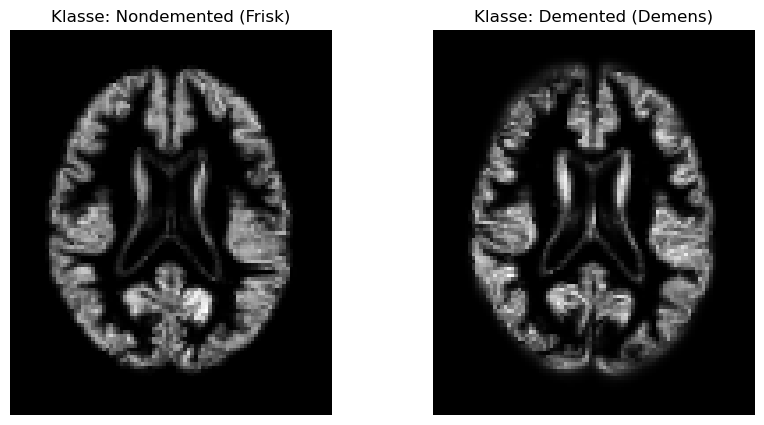

In [64]:
if len(images) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Finn første bilde av en frisk person
    nondemented_idx = np.where(labels == 0)[0][0]
    axes[0].imshow(images[nondemented_idx], cmap='gray')
    axes[0].set_title('Klasse: Nondemented (Frisk)')
    axes[0].axis('off')
    
    # Finn første bilde av en dement person
    demented_idx = np.where(labels == 1)[0][0]
    axes[1].imshow(images[demented_idx], cmap='gray')
    axes[1].set_title('Klasse: Demented (Demens)')
    axes[1].axis('off')
    
    plt.show()

### Steg 3: Forprosessering og Klargjøring av Data

For at et nevralt nettverk skal kunne behandle bildene, må vi:
1.  **Dele dataene** inn i et treningssett og et valideringssett.
2.  **Opprette en egendefinert `Dataset`-klasse** i PyTorch. Dette er standard praksis for å håndtere data effektivt.
3.  **Definere transformasjoner:** Bildene må konverteres til PyTorch-tensorer, få endret størrelse til en fast dimensjon (f.eks. 128x128), og normaliseres.

In [65]:
# 1. Del dataene i trenings- og valideringssett
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f'Størrelse på treningssett: {len(X_train)}')
print(f'Størrelse på valideringssett: {len(X_val)}')

# 2. Lag en egendefinert Dataset-klasse
class MRIDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Legg til en kanal-dimensjon (for gråtonebilder)
        image = np.expand_dims(image, axis=-1)
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# 3. Definer transformasjoner
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    # Normalisering med gjennomsnitt og standardavvik for datasettet
    # For enkelhets skyld bruker vi (0.5, 0.5) som er vanlig for bilder i [-1, 1] området
    transforms.Normalize((0.5,), (0.5,))
])

# Opprett Dataset- og DataLoader-objekter
train_dataset = MRIDataset(X_train, y_train, transform=data_transforms)
val_dataset = MRIDataset(X_val, y_val, transform=data_transforms)

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Størrelse på treningssett: 188
Størrelse på valideringssett: 47


### Steg 4: Bygge CNN-Modellen

Nå definerer vi arkitekturen til vårt nevrale nettverk. Vi lager en enkel CNN-modell med to konvolusjonslag etterfulgt av to fullt-tilkoblede (dense) lag.

**Arkitektur:**
1.  `Conv2d` -> `ReLU` -> `MaxPool2d` (Første konvolusjonsblokk)
2.  `Conv2d` -> `ReLU` -> `MaxPool2d` (Andre konvolusjonsblokk)
3.  `Flatten` (Gjør om 2D-kart til 1D-vektor)
4.  `Linear` -> `ReLU` (Første tette lag)
5.  `Linear` (Output-lag, som gir en score for hver klasse)

In [66]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Etter to pooling-lag vil et 128x128 bilde bli 32x32
        # Størrelsen på input til det lineære laget er 32 * 32 * 32 (kanaler)
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 2) # 2 klasser: nondemented og demented
        )

    def forward(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.fc_layer(x)
        return x

# Initialiser modellen og flytt den til GPU hvis tilgjengelig
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv_layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


### Steg 5: Trene Modellen

Nå er vi klare til å trene modellen. Vi må definere:
- **En tapsfunksjon (Loss Function):** Måler hvor feil modellen predikerer. `CrossEntropyLoss` er standard for klassifiseringsoppgaver.
- **En optimaliseringsalgoritme (Optimizer):** Oppdaterer vektene i nettverket for å minimere tapet. `Adam` er et robust og populært valg.

Deretter skriver vi en treningsløkke som itererer over dataene i et visst antall *epochs*. For hver epoch trener vi på treningssettet og evaluerer på valideringssettet for å overvåke ytelsen.

In [67]:
# 1. Sett standard dtype for torch
torch.set_default_dtype(torch.float32)

# 2. Konverter modellen til float32
model = model.float()

# 3. Definer hyperparametere
LEARNING_RATE = 0.001
EPOCHS = 20

# 4. Definer tapsfunksjon og optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 5. Initialiser historie for plotting
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


In [68]:
print("Starter trening...")
print(f"Bruker enhet: {device}")
print(f"Modell dtype: {next(model.parameters()).dtype}")

Starter trening...
Bruker enhet: mps
Modell dtype: torch.float32


In [ ]:
# 6. Treningsløkke
for epoch in range(EPOCHS):
    # --- Treningsfase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Eksplisitt konvertering til riktig dtype og device
        images = images.float().to(device)
        labels = labels.long().to(device)
        
        # Nullstill gradienter
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass og optimalisering
        loss.backward()
        optimizer.step()
        
        # Oppdater statistikk
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Print progress for hver 10. batch
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{EPOCHS}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')
        
    # Beregn gjennomsnittlig tap og nøyaktighet for treningssettet
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct_train / total_train
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # --- Valideringsfase ---
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Ingen grunn til å beregne gradienter her
        for images, labels in val_loader:
            # Eksplisitt konvertering til riktig dtype og device
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Oppdater statistikk
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Beregn gjennomsnittlig tap og nøyaktighet for valideringssettet
    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct_val / total_val
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print epoch resultater
    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    print('-' * 80)

print("Trening fullført!")

### Steg 6: Evaluere Modellen

Etter treningen er det viktig å evaluere modellens ytelse. Vi gjør dette på flere måter:
1.  **Plotte treningshistorikk:** Vi ser på hvordan tap og nøyaktighet utvikler seg over tid for både trenings- og valideringssettet. Dette kan avsløre problemer som *overfitting*.
2.  **Forvirringsmatrise (Confusion Matrix):** Viser en tabell over hvor mange bilder som ble korrekt og feilaktig klassifisert for hver klasse. Dette gir et mer detaljert bilde enn bare nøyaktighet.
3.  **Klassifiseringsrapport:** Gir en oppsummering av presisjon, sensitivitet (recall) og F1-score for hver klasse.

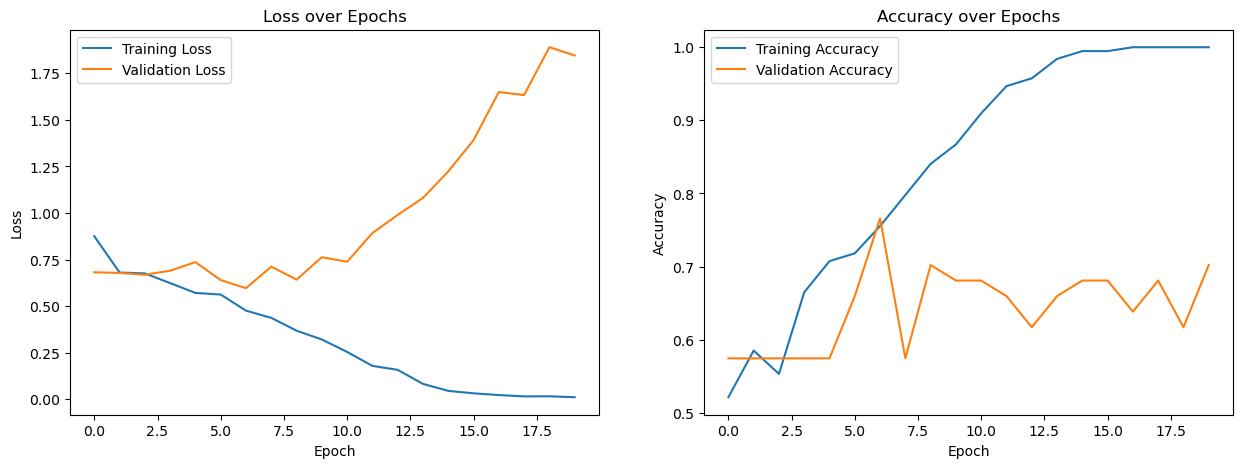

In [76]:
# 1. Plotte treningshistorikk
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history['train_loss'], label='Training Loss')
ax1.plot(history['val_loss'], label='Validation Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history['train_acc'], label='Training Accuracy')
ax2.plot(history['val_acc'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

Klassifiseringsrapport:
              precision    recall  f1-score   support

 Nondemented       0.74      0.74      0.74        27
    Demented       0.65      0.65      0.65        20

    accuracy                           0.70        47
   macro avg       0.70      0.70      0.70        47
weighted avg       0.70      0.70      0.70        47



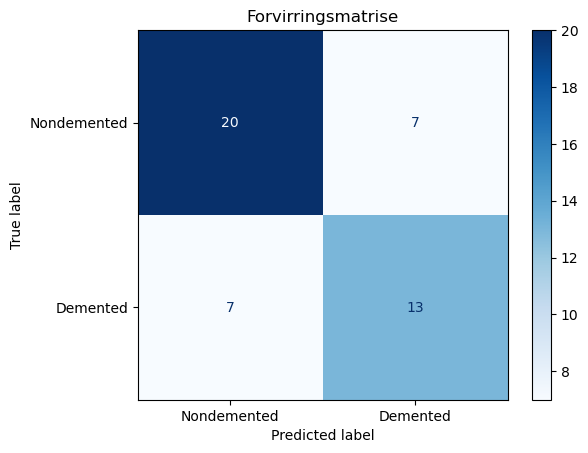

In [82]:
# 2 & 3. Forvirringsmatrise og klassifiseringsrapport
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        # Eksplisitt konvertering til float32 for MPS-kompatibilitet
        images = images.float().to(device)
        labels = labels.long().to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

class_names = ['Nondemented', 'Demented']
print("Klassifiseringsrapport:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Forvirringsmatrise')
plt.show()

### Konklusjon

I denne notebook-en har vi bygget en ende-til-ende-løsning for klassifisering av MR-bilder ved hjelp av PyTorch.

Vi har:
1.  Lastet inn og forprosessert medisinske bilder i NIfTI-format.
2.  Definert en egendefinert `Dataset`-klasse for å håndtere dataene i PyTorch.
3.  Bygget og trent en enkel CNN-modell fra bunnen av.
4.  Evaluert modellens ytelse med relevante metrikker som nøyaktighet, forvirringsmatrise og klassifiseringsrapport.

Dette er et startpunkt. For å forbedre modellen kan man utforske:
- **Dataaugmentering:** Roter, zoom eller flipp bildene for å kunstig øke størrelsen på treningssettet.
- **Mer avanserte arkitekturer:** Bruk forhåndstrente modeller som ResNet (transfer learning).
- **3D-konvolusjoner:** Utnytt den fulle 3D-informasjonen i MR-skanningene ved å bruke `Conv3d`-lag.